<a href="https://colab.research.google.com/github/android-kunjapppan/Rubic-s-Cube-2x2x2/blob/master/Rubic's_cube_2x2x2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
%matplotlib inline

In [2]:
def operation(axis, clockwise):
    """Every possible operation on the rubics cube is given a number from 0 to 5"""
    return 2*axis + clockwise

mapping_rotation_identity = np.array([-3,-2,-1, 1, 2, 3], dtype=np.int8)

mapping_rotation_all = np.array([[-2, 3,-1, 1,-3, 2], 
                                 [ 2,-3,-1, 1, 3,-2], 
                                 [ 1,-2,-3, 3, 2,-1], 
                                 [-1,-2, 3,-3, 2, 1], 
                                 [-3,-1, 2,-2, 1, 3], 
                                 [-3, 1,-2, 2,-1, 3]],  dtype=np.int8)

mapping_position_all = np.array([[0,1,2,3,6,4,7,5],
                                 [0,1,2,3,5,7,4,6], 
                                 [0,1,3,7,4,5,2,6],
                                 [0,1,6,2,4,5,7,3],
                                 [0,5,2,1,4,7,6,3],
                                 [0,3,2,7,4,1,6,5]], dtype=np.int8)

      
@jit('void(i1[:], i1[:], i1)', nopython=True)    
def turn_once(positions, rotations, operation):
    # Position Update
    mapping_position = mapping_position_all[operation]
    positions[:] = positions[mapping_position]
    changed_corners = np.where(mapping_position!=np.arange(8))[0]
    # Rotation Update
    palette = mapping_rotation_identity
    key = mapping_rotation_all[operation]                             
    index = np.digitize(rotations[changed_corners], palette, right=True)
    rotations[changed_corners] = key[index]
    rotations[:] = rotations[mapping_position]


@jit('void(i1[:], i1[:], i1[:], i1[:,:], i1[:,:])', nopython=True)  
def turn_multiple(positions_start, rotations_start, operations, positions_results, rotations_results):
    for i, operation in enumerate(operations):
        positions_results[i], rotations_results[i] = positions_start, rotations_start
        turn_once(positions_start, rotations_start, operation)
        
def initialise_cube():
    positions = np.arange(8).astype(np.int8) # Which corner is where relative to whiteblueorange.
    rotations = np.array([-1,-1,-1,-1,1,1,1,1]).astype(np.int8) #Which direction is white or yellow face looking 
    return positions, rotations

In [3]:
def plot_cube_configurations(ax, positions, rotations, operations, aspect=0.5):
    result = np.hstack((positions, rotations))
    ax.imshow(result, aspect=aspect, cmap='jet', vmin=-3, vmax=7)
    for i,line in enumerate(result):
        for j,field in enumerate(line):
            ax.text(s=field, x=j, y=i+0.25, fontsize=5)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    for i,op in enumerate(operations):
        ax.text(s='Ax:%s C:%s'%(op//2, op%2), x=-2, y=i + 0.25, fontsize=6)
    for i,(text,num) in enumerate(zip(['Pos']*8 + ['Rot']*8, list(range(8))*2)):
        ax.text(s='%s%s'%(text,num), x=i-0.25, y=-1, fontsize=6)

In [4]:
positions, rotations = initialise_cube()

In [5]:
%timeit turn_once(positions, rotations, 1)

The slowest run took 279.58 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 1.31 µs per loop


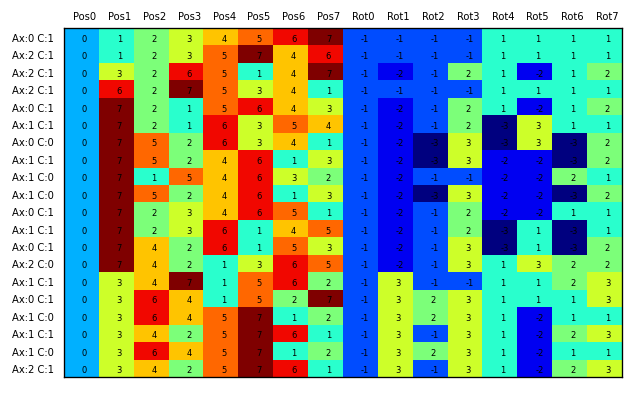

In [6]:
positions, rotations = initialise_cube()
n=5000
positions_results = np.zeros((n,8), dtype=np.int8)
rotations_results = np.zeros((n,8), dtype=np.int8)
operations = np.random.randint(0,6,n).astype(np.int8)
turn_multiple(positions, rotations, operations, positions_results, rotations_results)

max_plot = 20
fig,ax = plt.subplots(dpi=120)
plot_cube_configurations(ax, positions_results[0:max_plot], rotations_results[0:max_plot], operations[0:max_plot])

In [7]:
positions, rotations = initialise_cube()

positions_results = np.zeros((n,8), dtype=np.int8)
rotations_results = np.zeros((n,8), dtype=np.int8)
operations = [0]*20
turn_multiple(positions, rotations, np.array(operations).astype(np.int8), positions_results, rotations_results)

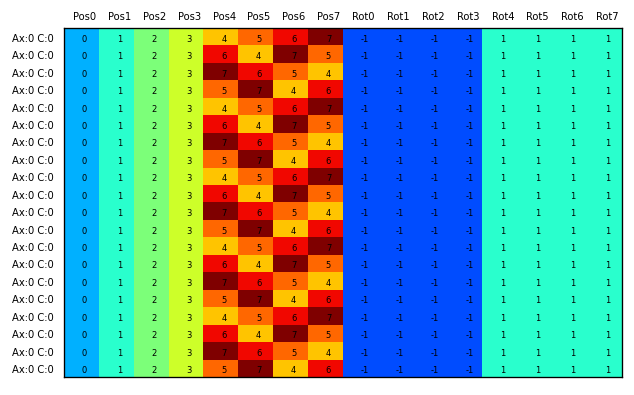

In [8]:
max_plot = 20
fig,ax = plt.subplots(dpi=120)
plot_cube_configurations(ax, positions_results[0:max_plot], rotations_results[0:max_plot], operations[0:max_plot])

In [9]:
positions, rotations = initialise_cube()
n=10000000
positions_results = np.zeros((n,8), dtype=np.int8)
rotations_results = np.zeros((n,8), dtype=np.int8)
operations = np.random.randint(0,6,n).astype(np.int8)
turn_multiple(positions, rotations, operations, positions_results, rotations_results)

In [10]:
result = np.hstack((positions_results, rotations_results))
solved_positions = np.where((result == result[0]).sum(1) == 16)[0]

In [11]:
solved_positions

array([      0, 6760276, 8110024])

In [12]:
print('It does, %s out of %s times.'%(len(solved_positions)-1,n))

It does, 2 out of 10000000 times.


In [13]:
positions, rotations = initialise_cube()
already_visited = []
number_of_permutations = []
counter = 0
random_number = np.random.randint(0,6)
new_random_number = random_number

for i in range(20000):
    string = '.'.join((np.hstack((positions, rotations))).astype('str'))
    new_random_number = np.random.randint(0,6)
    while new_random_number == random_number:
        new_random_number = np.random.randint(0,6)
    random_number = new_random_number
    turn_once(positions, rotations, random_number)
    if string not in already_visited:
        already_visited.append(string)
        counter += 1    
    number_of_permutations.append(counter)

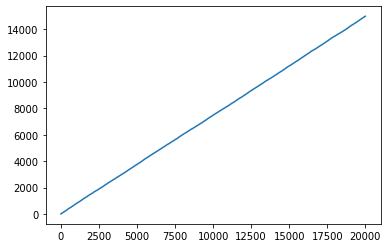

In [14]:
plt.plot(number_of_permutations)

In [15]:
def to_binary(arr):
    arr = np.clip(arr, 0,5)
    return np.array([['0']*(2-i//2)+list("{0:b}".format(i)) for i in arr]).astype(int)

def operation_binary_to_integer(arr):
    return (np.array([0,1,2,3,4,5]) * arr).sum(1)

def operation_integer_to_binary(operations_total):
    operations_total_binary = np.zeros((len(operations_total),6), dtype=bool)
    for i in range(6):
        operations_total_binary[:,i] = (operations_total == i)
    return operations_total_binary

def operation_integer_reverse(arr):
    return arr - arr%2 + np.logical_not(arr%2)

def results_integer_to_binary(results_total):
    results_total_binary = np.zeros((len(results_total),48), dtype=bool)
    for i in range(8):
        results_total_binary[:, 3*i:3*i+3] = to_binary(results_total[:,i])
        results_total_binary[:, 24+3*i:24+3*i+3] = to_binary(results_total[:,i+8]+3)
    return results_total_binary

In [16]:
number_scramblings = 20000
depth_scrambling = 14

results_total = []
operations_total = []

for i in range(number_scramblings//10):
    positions, rotations = initialise_cube()
    n = np.random.randint(5,depth_scrambling+1)
    positions_results = np.zeros((n,8), dtype=np.int8)
    rotations_results = np.zeros((n,8), dtype=np.int8)
    
    operations = []
    random = np.random.randint(6)
    for i in range(n):
        operations.append(random)
        randomnew = operation_integer_reverse(np.array(random))
        while (randomnew == operation_integer_reverse(np.array(random))):
            randomnew = np.random.randint(6)
        random = randomnew
    operations = np.array(operations, dtype=np.int8)
    #operations = np.random.randint(0,6,n).astype(np.int8)
    
    turn_multiple(positions, rotations, operations, positions_results, rotations_results)
    results = np.hstack((positions_results, rotations_results))
    results_total.append(results[1:])
    operations_total.append(operations[:-1])
    
for i in range(number_scramblings):
    positions, rotations = initialise_cube()
    n = np.random.randint(3,8+1)
    positions_results = np.zeros((n,8), dtype=np.int8)
    rotations_results = np.zeros((n,8), dtype=np.int8)
    
    operations = []
    random = np.random.randint(6)
    for i in range(n):
        operations.append(random)
        randomnew = operation_integer_reverse(np.array(random))
        while (randomnew == operation_integer_reverse(np.array(random))):
            randomnew = np.random.randint(6)
        random = randomnew
    operations = np.array(operations, dtype=np.int8)
    
    turn_multiple(positions, rotations, operations, positions_results, rotations_results)
    results = np.hstack((positions_results, rotations_results))
    results_total.append(results[1:])
    operations_total.append(operations[:-1])
    
results_total = np.vstack((results_total))
operations_total = np.hstack((operations_total))


results_total_binary = results_integer_to_binary(results_total)
operations_total_binary = operation_integer_to_binary(operation_integer_reverse(operations_total))

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Activation, BatchNormalization, Dropout

import keras
import keras.backend as K

def correctness(y_true, y_pred):
    def int_y(arr):
       return K.sum((np.array([4,2,0,1]) * arr), axis=1)
    corr = K.equal(int_y(y_true), int_y(K.round(y_pred)))
    return corr# / len(corr)

model = Sequential()

#input
model.add(Dense(units=48, input_dim=48))
#model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Dropout(0.5))

model.add(Dense(units=48))
#model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Dropout(0.5))

model.add(Dense(units=48))
# #model.add(BatchNormalization())
model.add(Activation('relu'))
#model.add(Dropout(0.5))

model.add(Dense(units=6))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adadelta(lr=1, rho=0.95, epsilon=1e-08, decay=0.0),
              metrics=['acc']) #'mae', 'acc',  #'binary_crossentropy'

In [18]:
model.fit(results_total_binary, operations_total_binary, batch_size=100, epochs=5, verbose=1, 
    callbacks=None, validation_split=0.2, 
    validation_data=None, shuffle=True, class_weight=None, 
    sample_weight=None, initial_epoch=0)

Epoch 1/5
857/857 [==============================] - 1s 2ms/step - loss: 1.0389 - acc: 0.6267 - val_loss: 0.7621 - val_acc: 0.7265
Epoch 2/5
857/857 [==============================] - 1s 1ms/step - loss: 0.8267 - acc: 0.7022 - val_loss: 0.6843 - val_acc: 0.7547
Epoch 3/5
857/857 [==============================] - 1s 1ms/step - loss: 0.7715 - acc: 0.7228 - val_loss: 0.6464 - val_acc: 0.7654
Epoch 4/5
857/857 [==============================] - 1s 1ms/step - loss: 0.7392 - acc: 0.7330 - val_loss: 0.6206 - val_acc: 0.7768
Epoch 5/5
857/857 [==============================] - 1s 1ms/step - loss: 0.7168 - acc: 0.7419 - val_loss: 0.6042 - val_acc: 0.7835


In [19]:
correct = operation_binary_to_integer(model.predict(results_total_binary)>0.5) == operation_binary_to_integer(operations_total_binary)

In [20]:
print('Percentage of correct predictions: %.2f %%'%(100*correct.sum()/len(correct)))

Percentage of correct predictions: 70.65 %


solved in run 9
scramb with 5.0.2.5.3
solved with 0.4.0.3.1.1.0.5.5


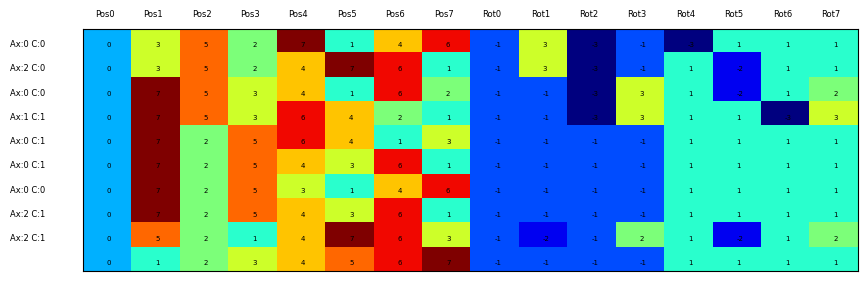

In [21]:
positions, rotations = initialise_cube()
results_when_solved = np.hstack((positions, rotations))
scrambling = []
random = np.random.randint(6)
for i in range(5):
    randomnew = operation_integer_reverse(np.array(random))
    while (randomnew == operation_integer_reverse(np.array(random))):
        randomnew = np.random.randint(6)
    random = randomnew
    scrambling.append(random)
    turn_once(positions, rotations, random)
scrambling= operation_integer_reverse(np.array(scrambling))[::-1]

    
positions_plot = []
rotations_plot = []
operations_plot = []
# solving
for i in range(5000):
    positions_plot.append(positions.copy())
    rotations_plot.append(rotations.copy())
    results = np.hstack((positions, rotations))
    results_binary =  results_integer_to_binary(results[np.newaxis, :])
    #print(results)
    if (results == results_when_solved).sum()==16:
        print('solved in run %s'%i)
        print('scramb with %s'%(".".join([str(i) for i in scrambling[::-1]])))
        print('solved with %s'%(".".join([str(i) for i in operations_plot])))
        break
    prediction = model.predict(results_binary)
    certainty = np.diff(sorted(prediction[0]))[-1]
    prediction += np.random.randn(6) * 0.3#* (1-certainty)  * (1-np.exp(-i/100)) * 10 #
    prediction_integer = prediction.argmax()
    #if certainty<0.5:
    #    prediction_integer=np.random.randint(6)
    np.set_printoptions(precision=2)
    #print(prediction_integer, prediction)
    turn_once(positions, rotations, prediction_integer)
    operations_plot.append(prediction_integer)
    if np.random.randn()>1.5:
        for i in range(6):
            turn_once(positions, rotations, np.random.randint(6))
        
    
fig, ax = plt.subplots(dpi=100, figsize=(10,20))
plot_cube_configurations(ax,positions_plot[-15:], 
                         rotations_plot[-15:], 
                         operations_plot[-15:], aspect=0.5)

(-3.0, 4.0)

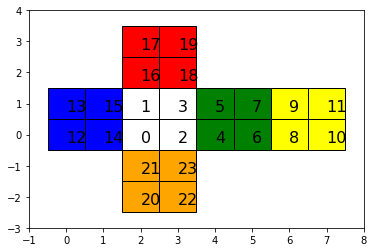

In [24]:
fig, ax = plt.subplots()

colors= ['white', 'green', 'yellow', 'blue', 'red', 'orange']
centers = np.array([(1,0), (2,0),  (3,0), (0,0), (1,1), (1,-1)])*2


count = 0
for col,cent in zip(colors, centers):
    for dx in [-1,1]:
        for dy in [-1,1]:
            pos = np.array(cent)+np.array([dx,dy])/2
            ax.add_patch(plt.Rectangle(pos, 1, 1, facecolor=col, linewidth=1, edgecolor='k'))
            ax.text(s='%s'%count, x = pos[0]+0.5, y=pos[1]+1/4, fontsize=16)
            count += 1
            
    
plt.xlim(-1,8)
plt.ylim(-3,4)